In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.nn import Module
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda:1')
print(device)

cuda:1


In [3]:
class Hyperparameter():
    def __init__(self):
        self.dict = {}
        self.dict['optimizer'] = {}
        self.dict['optimizer']['lr'] = [1e-4, 5.5e-6]
        self.dict['optimizer']['beta'] = [(0.9, 0.999), (0.9, 0.999)]
        self.dict['optimizer']['eps'] = [1e-7, 1e-7]
        self.dict['optimizer']['method'] = 'Adam'
    
        self.dict['epoch'] = [100, 100]
        self.dict['batch_size'] = 32
        self.dict['patience'] = 20
        self.dict['min_delta'] = 1e-4
        
        self.dict['training_data'] = {}
        self.dict['training_data']['path'] = '/home/chenyu/Desktop/CNNmeasurement/TrainingData_CoarseCNN/'
        self.dict['training_data']['data'] = 'FullRandom_50mrad_2ndOrder_highAbr_whiteNoise_32pxGaussian_multiNoise_30pA_128pxRonch_x25000.npy'
        self.dict['training_data']['label_1'] = 'FullRandom_50mrad_2ndOrder_highAbr_whiteNoise_32pxGaussian_multiNoise_30pA_45mradnewEmit_x25000.npy'
        self.dict['training_data']['label_2'] = 'FullRandom_50mrad_2ndOrder_highAbr_whiteNoise_32pxGaussian_multiNoise_30pA_defocus_x25000.npy'
        self.dict['training_data']['split'] = 0.8
        self.dict['training_data']['aperture'] = 45
        self.dict['training_data']['limit'] = 50
        
        self.dict['segmentation'] = {}
        self.dict['segmentation']['resize'] = (135, 135)
        self.dict['segmentation']['ratio'] = (0.97, 1.03)
        self.dict['segmentation']['scale'] = (0.9, 1.0)
        self.dict['segmentation']['normalize'] = None
        
        self.dict['architecture'] = {}
        self.dict['architecture']['dropout'] = 0.5
        self.dict['architecture']['linear_shape'] = [256]
        
        self.process = {}
        
        self.process['training'] = []
        self.process['validation'] = []
        
    def add_training_process(self, training_acc, validation_acc, epoch):
        if epoch == 0:
            self.process['training'].append([])
            self.process['validation'].append([])
        if torch.is_tensor(training_acc):
            training_acc = training_acc.cpu().detach().numpy()
        if torch.is_tensor(validation_acc):
            validation_acc = validation_acc.cpu().detach().numpy()
        self.process['training'][-1].append(training_acc)
        self.process['validation'][-1].append(validation_acc)
        return
    
    def save_result(self, path):
        with open(path + 'hyperparameter.pkl', 'wb') as f:
            pickle.dump(self.dict, f)
        with open(path + 'training_log.pkl', 'wb') as f:
            pickle.dump(self.process, f)

In [4]:
par = Hyperparameter()

In [5]:
# Customized CNN model
class Net(Module):   
    def __init__(self, pretrained = False, dropout = 0.3, linear_shape = 512):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv2 = nn.Conv2d(64, 64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv3 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv4 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv5 = nn.Conv2d(128, 256, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv6 = nn.Conv2d(256, 256, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv7 = nn.Conv2d(256, 256, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv8 = nn.Conv2d(256, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv9 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv10 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv11 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv12 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv13 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.fc1 = nn.Linear(4 * 4 * 512, linear_shape)
        self.dropout = nn.Dropout(p = dropout)
#         self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(linear_shape, 1)
    
    def lock_base(self):
        for parameter in self.parameters():
            parameter.requires_grad = False
        self.fc1.weight.requires_grad = True
        self.fc1.bias.requires_grad = True
#         self.fc2.weight.requires_grad = True
#         self.fc2.bias.requires_grad = True
        self.fc3.weight.requires_grad = True
        self.fc3.bias.requires_grad = True
    
    def unlock_base(self):
        for parameter in self.parameters():
            parameter.requires_grad = True
            
    def load_pretrained(self):
        print("Loading weights and bias from VGG16.")
        vgg16 = torchvision.models.vgg16(pretrained = True)
        self.conv1.weight.data = vgg16.features[0].weight.data.to(device = device)
        self.conv1.bias.data = vgg16.features[0].bias.data.to(device = device)
        self.conv2.weight.data = vgg16.features[2].weight.data.to(device = device)
        self.conv2.bias.data = vgg16.features[2].bias.data.to(device = device)
        self.conv3.weight.data = vgg16.features[5].weight.data.to(device = device)
        self.conv3.bias.data = vgg16.features[5].bias.data.to(device = device)
        self.conv4.weight.data = vgg16.features[7].weight.data.to(device = device)
        self.conv4.bias.data = vgg16.features[7].bias.data.to(device = device)
        self.conv5.weight.data = vgg16.features[10].weight.data.to(device = device)
        self.conv5.bias.data = vgg16.features[10].bias.data.to(device = device)
        self.conv6.weight.data = vgg16.features[12].weight.data.to(device = device)
        self.conv6.bias.data = vgg16.features[12].bias.data.to(device = device)
        self.conv7.weight.data = vgg16.features[14].weight.data.to(device = device)
        self.conv7.bias.data = vgg16.features[14].bias.data.to(device = device)
        self.conv8.weight.data = vgg16.features[17].weight.data.to(device = device)
        self.conv8.bias.data = vgg16.features[17].bias.data.to(device = device)
        self.conv9.weight.data = vgg16.features[19].weight.data.to(device = device)
        self.conv9.bias.data = vgg16.features[19].bias.data.to(device = device)
        self.conv10.weight.data = vgg16.features[21].weight.data.to(device = device)
        self.conv10.bias.data = vgg16.features[21].bias.data.to(device = device)
        self.conv11.weight.data = vgg16.features[24].weight.data.to(device = device)
        self.conv11.bias.data = vgg16.features[24].bias.data.to(device = device)
        self.conv12.weight.data = vgg16.features[26].weight.data.to(device = device)
        self.conv12.bias.data = vgg16.features[26].bias.data.to(device = device)
        self.conv13.weight.data = vgg16.features[28].weight.data.to(device = device)
        self.conv13.bias.data = vgg16.features[28].bias.data.to(device = device)
    
    # Defining the forward pass    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [6]:
# prepare the training data
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

In [7]:
input_path = par.dict['training_data']['path']
train_data = np.load(input_path + par.dict['training_data']['data'])
print(train_data.shape)

train_label = np.load(input_path + par.dict['training_data']['label_1'])
train_label_1 = (train_label - np.amin(train_label))/(np.amax(train_label) - np.amin(train_label))
print(train_label.shape)

train_label = np.load(input_path + par.dict['training_data']['label_2'])
train_label_2 = (train_label - np.amin(train_label))/(np.amax(train_label) - np.amin(train_label))
print(train_label.shape)

train_label = (train_label_1 + train_label_2) / 2

(25010, 128, 128)
(25010,)
(25010,)


In [8]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input    

In [9]:
def aperture_generator(px_size, simdim, ap_size):
    x = np.linspace(-simdim, simdim, px_size)
    y = np.linspace(-simdim, simdim, px_size)
    xv, yv = np.meshgrid(x, y)
    apt_mask = mask = np.sqrt(xv*xv + yv*yv) < ap_size # aperture mask
    return apt_mask

In [10]:
if par.dict['training_data']['aperture'] != 0:
    aperture_mask = aperture_generator(128, par.dict['training_data']['limit'], 
                                       par.dict['training_data']['aperture'])

In [11]:
class RonchigramDataset(Dataset):
    def __init__(self, data, labels, transform = None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = scale_range(self.data[index,:,:].astype('float'), 0, 1)
        if par.dict['training_data']['aperture'] != 0:
            img = img * aperture_mask
        new_channel = np.zeros(img.shape)
        img = np.dstack((img, new_channel, new_channel))
        img = Image.fromarray(np.uint8(img * 255))
        y_label = torch.tensor(float(self.labels[index]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [12]:
transform = transforms.Compose(
        [
            transforms.Resize(par.dict['segmentation']['resize']),
            transforms.RandomRotation(90),
            transforms.RandomResizedCrop((128, 128), scale = par.dict['segmentation']['scale'], ratio = par.dict['segmentation']['ratio']),
            transforms.ToTensor(),
            # TODO: need to add random shear here
            # option to normalize a tensor with mean and standard deviation, similar to featurewise center in Keras
#             transforms.Normalize((1.0, 1.0, 1.0), (1.0, 1.0, 1.0)),
        ]
    )

In [13]:
# training hyperparameters
train_CNN = False
batch_size = par.dict['batch_size']
shuffle = True
pin_memory = True
num_workers = 1

In [14]:
dataset = RonchigramDataset(train_data, train_label, transform = transform)

n_train = int(len(train_data) * par.dict['training_data']['split'])
n_val = len(train_data) - n_train
train_set, validation_set = torch.utils.data.random_split(dataset,[n_train,n_val])

train_loader = DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)

validation_loader = DataLoader(dataset=validation_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)

In [15]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

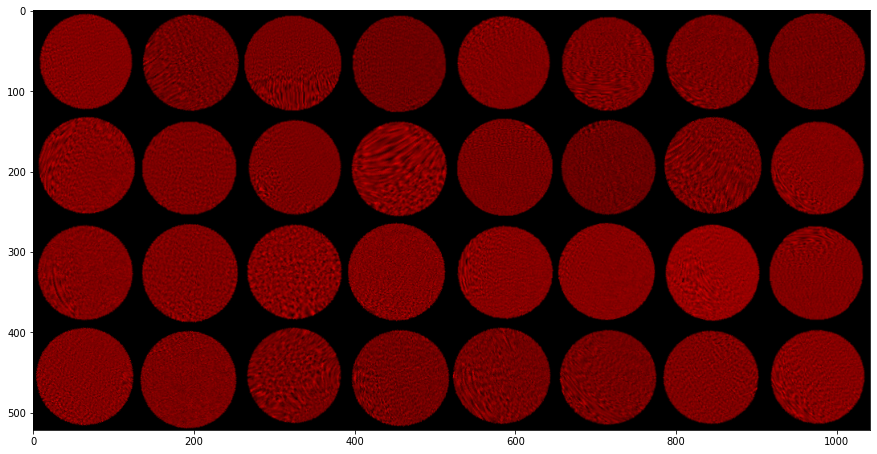

In [16]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.colorbar()
    plt.show()

fig = plt.figure(figsize = [15,9])
imshow(torchvision.utils.make_grid(images))

In [17]:
# Call the CNN model and start training
model = Net(dropout = par.dict['architecture']['dropout'], linear_shape = par.dict['architecture']['linear_shape'][0]).to(device)
model.load_pretrained()
model.lock_base()
criterion = nn.MSELoss(reduction = 'mean')

Loading weights and bias from VGG16.


In [18]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.to(device)
print(images.shape)
print(model.conv1.weight.data.shape)
x = F.relu(model.conv1(images))
print(x.shape)
print(model.conv2.weight.data.shape)
x = model.conv2(x)
print(x.shape)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


torch.Size([32, 3, 128, 128])
torch.Size([64, 3, 3, 3])
torch.Size([32, 64, 128, 128])
torch.Size([64, 64, 3, 3])
torch.Size([32, 64, 128, 128])


In [19]:
def check_accuracy(loader, model):
    if loader == train_loader:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on validation data")

    sum_MSE = 0
    counter = 0
    loss = nn.MSELoss(reduction = 'mean')
    model.eval()
    
    # define two lists to save truth and predictions, for the plot only.
    y_list = torch.empty(0).to(device = device)
    pred_list = torch.empty(0).to(device = device)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            pred = torch.squeeze(model(x))
            pred_list = torch.cat((pred_list, pred), 0)
            y_list = torch.cat((y_list, y), 0)
            sum_MSE += loss(pred, y) * y.shape[0]
            counter += y.shape[0]
    
    fig, ax = plt.subplots(1,1, figsize = (5,5))
    img = ax.scatter(y_list.cpu().numpy(), pred_list.cpu().numpy(), s = 1)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.plot(np.linspace(0,1,100), np.linspace(0,1,100),'--', c = 'red')
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel('Truth',fontsize = 16)
    ax.set_ylabel('Prediction', fontsize = 16)
    plt.show()
    
    model.train()
#     print( f"Got accuracy {float(sum_MSE)/float(counter):.6f}" )   
    return f"{float(sum_MSE)/float(counter):.6f}"
    
#     model.train()

In [20]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience = 5, min_delta = 0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [21]:
def train():
    early_stopping = EarlyStopping(patience = par.dict['patience'], min_delta = par.dict['min_delta'])
    model.train()
    for epoch in range(num_epochs):
        loop = tqdm(train_loader, total = len(train_loader), leave = True)
        
        if epoch % 2 == 0:
            val_acc = check_accuracy(validation_loader, model)
            loop.set_postfix(val_acc = val_acc)
            early_stopping(float(val_acc))
            if early_stopping.early_stop:
                par.add_training_process(acc_loss / counter , float(val_acc), epoch)
                break
                
        acc_loss = 0
        counter = 0
        
        for imgs, labels in loop:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = torch.squeeze(model(imgs))
            loss = criterion(outputs, labels)
            acc_loss += loss * labels.shape[0]
            counter += labels.shape[0]
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
            loop.set_postfix(loss = loss.item())
        
        par.add_training_process(acc_loss / counter , val_acc, epoch)
        print(f"Training acc: {float(acc_loss) / float(counter):.6f}, Validation accuracy {float(val_acc):.6f}")

  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


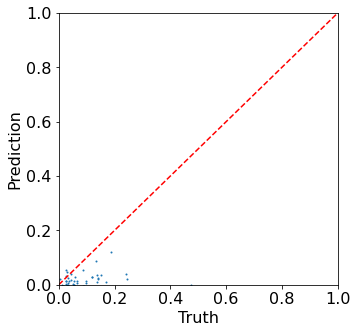

Epoch [0/100]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:47<00:00, 13.18it/s, loss=0.0251]


Training acc: 0.043170, Validation accuracy 0.560837


Epoch [1/100]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:42<00:00, 14.66it/s, loss=0.0497]


Training acc: 0.029951, Validation accuracy 0.560837


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


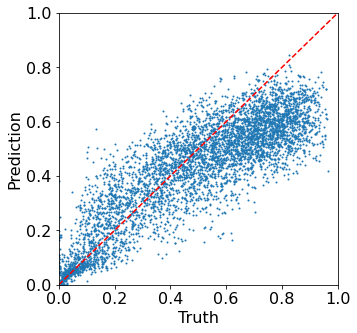

Epoch [2/100]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:54<00:00, 11.47it/s, loss=0.0202]


Training acc: 0.028727, Validation accuracy 0.023770


Epoch [3/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:42<00:00, 14.89it/s, loss=0.00747]


Training acc: 0.027383, Validation accuracy 0.023770


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


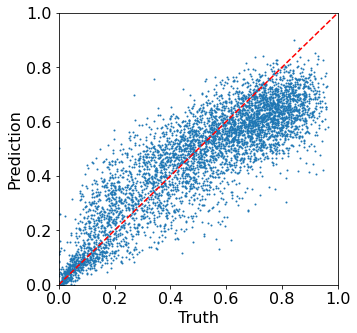

Epoch [4/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:49<00:00, 12.55it/s, loss=0.02]


Training acc: 0.025971, Validation accuracy 0.018293


Epoch [5/100]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:40<00:00, 15.53it/s, loss=0.0067]


Training acc: 0.025103, Validation accuracy 0.018293


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


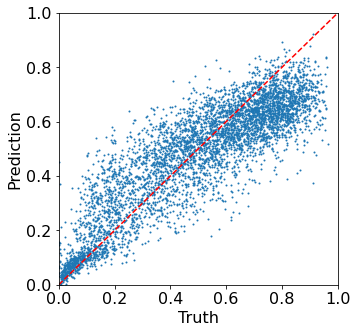

Epoch [6/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:49<00:00, 12.77it/s, loss=0.00464]


Training acc: 0.023939, Validation accuracy 0.016836


Epoch [7/100]:   4%|█████▋                                                                                                                                    | 26/626 [00:01<00:37, 15.84it/s, loss=0.026]

In [ ]:
stage = 0
learning_rate = par.dict['optimizer']['lr'][stage]
num_epochs = par.dict['epoch'][stage]
betas = par.dict['optimizer']['beta'][stage]
eps = par.dict['optimizer']['eps'][stage]
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = betas, eps = eps)
train()

In [ ]:
stage = 1
learning_rate = par.dict['optimizer']['lr'][stage]
num_epochs = par.dict['epoch'][stage]
betas = par.dict['optimizer']['beta'][stage]
eps = par.dict['optimizer']['eps'][stage]
model.unlock_base()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = betas, eps = eps)
train()

In [ ]:
fig = plt.figure(figsize=[15,5])

ax = fig.add_subplot(121)
ax.plot(np.array(par.process['training'][0]), '.', markersize = 10 , label = 'training')
ax.plot(np.array(par.process['validation'][0], dtype = 'float'), '.', markersize = 10 , label = 'validation')
ax.set_yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(which='major',direction = 'in', length = 10, width = 2)
plt.tick_params(which='minor',direction = 'in', length = 5)
ax.set_xlabel('Training Epoch',fontsize = 16)
ax.set_ylabel('Normalized RMSE', fontsize = 16)
plt.legend(fontsize = 16)

ax = fig.add_subplot(122)
ax.plot(np.array(par.process['training'][1]), '.', markersize = 10 , label = 'training')
ax.plot(np.array(par.process['validation'][1], dtype = 'float'), '.', markersize = 10 , label = 'validation')
ax.set_yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(which='major',direction = 'in', length = 10, width = 2)
plt.tick_params(which='minor',direction = 'in', length = 5)
ax.set_xlabel('Training Epoch',fontsize = 16)
ax.set_ylabel('Normalized RMSE', fontsize = 16)
plt.legend(fontsize = 16)

In [ ]:
torch.save(model.state_dict(), 'TorchModels/Test18_Nion_2ndorder_45mradApt_50mradLimit_emit+defocus_Adam_attempt09-2.pt')
par.save_result('TorchModels/Test18_Nion_2ndorder_45mradApt_50mradLimit_emit+defocus_Adam_attempt09-2_')

In [ ]:
file = open("TorchModels/Test18_Nion_2ndorder_45mradApt_50mradLimit_emit+defocus_Adam_attempt09-2_hyperparameter.pkl",'rb')
object_file = pickle.load(file)
file.close()

In [ ]:
file = open("TorchModels/Test18_Nion_2ndorder_45mradApt_50mradLimit_emit+defocus_Adam_attempt09-2_training_log.pkl",'rb')
object_file = pickle.load(file)
file.close()

In [ ]:
print(object_file['training'][0][-1])
print(object_file['validation'][0][-1])
print(object_file['training'][1][-1])
print(object_file['validation'][1][-1])

In [ ]:
def scale_range_aperture_2(img, min, max):
    mask = aperture_generator(128, 50, 40)
    array = np.ndarray.flatten(img[np.where(mask==1)])
    img = img - np.amin(array)
    img = img / (np.amax(array) - np.amin(array))
    img = img * (max - min)
    img += min
    img[np.where(mask == 0)] = 0
    return img

In [ ]:
abr_list = ["C10", "C12.x", "C12.y", "C21.x", "C21.y", "C23.x", "C23.y", "C30", 
"C32.x", "C32.y", "C34.x", "C34.y"]

abr_lim = [2e-6, 1.5e-6, 1.5e-6, 3e-5, 3e-5, 1e-5, 1e-5, 3e-4, 2e-4, 2e-4, 1.5e-4, 1.5e-4]
abr_default = [2e-9, 2e-9, 2e-9, 20e-9, 20e-9, 20e-9, 20e-9, 0.5e-6, 1e-6, 1e-6, 1e-6, 1e-6]

In [ ]:
abr_coeff = 'C1'
dwell_time = 250
path = '/home/chenyu/Desktop/NionData/090921/250ms_linescan_Aligned/'
# path = '/home/chenyu/Desktop/NionData/090221_50mrad_linescans/'
file_list = glob.glob(path + abr_coeff +'*'+str(dwell_time)+'ms_bin1_repx5voaFOV.npy')
print(file_list)

In [ ]:
# ronch_list = np.load('NionRelated/C12.y_2e-06m_100steps_10ms_bin8.npy')
nsteps = 100
nrep = 5
x_list = []
y_list = []
t_list = []
coeff_list = []
x_default = [(abr_default[i] + abr_lim[i]/2) / abr_lim[i] for i in range(len(abr_list))]

for file in file_list:
    name_list = file.replace('/','_').split('_')
    print(file, name_list)
    abr_coeff = name_list[-6]
    idx = abr_list.index(abr_coeff)
    abr_range = abr_lim[idx]
    value_list = [(i - nsteps//2) * abr_range / nsteps for i in range(nsteps)]
    ronch_list = np.load(file)
    frame_list = []
    pred = []
    
    for i in range(nsteps):
        for j in range(nrep):
            x = [x_default[j] for j in range(len(x_default))]
            x[idx] = (value_list[i] + abr_range / 2) / abr_range
            x_list.append(x)
            frame = ronch_list[i * nrep + j,:,:]
            frame = scale_range_aperture_2(frame, 0, 1)
            new_channel = np.zeros(frame.shape)
            img_stack = np.dstack((frame, new_channel, new_channel))
            x = torch.tensor(np.transpose(img_stack)).to(device)
            x = x.unsqueeze(0).float()
            prediction = model(x)
            pred.append(prediction[0][0].cpu().detach().numpy())
            
    y_list.append(np.array(pred))
    t_list.append(name_list[-3])
    coeff_list.append(abr_coeff)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = [8,6])
y_list_avg = []
x_list_avg = np.array(x_list[::5])
std_list = np.zeros(nsteps)

for i in range(len(t_list)):
    temp = y_list[i].reshape([nsteps, 5])
    y_list_avg.append(temp.mean(-1))
    for j in range(nsteps):
        std_list[j] = np.std(temp[j,:])
    p = ax.plot(np.array(value_list) * 1e6, temp.mean(-1), linewidth = 2, label = coeff_list[i])
#     p = ax.plot(np.array(value_list) * 1e6, temp.mean(-1), linewidth = 2, label = t_list[i])
#         p = ax.plot(temp.mean(-1), linewidth = 2, label = coeff_list[i])
    ax.fill_between(np.array(value_list) * 1e6, temp.mean(-1) - np.array(std_list), 
                    temp.mean(-1) + np.array(std_list), alpha = 0.3)

ax.set_xlabel('Aberration Coefficients (um)',fontsize = 16)
ax.set_ylabel('Normalized Defocus + Emit', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(fontsize = 16)